<h1 align=center> Graph Convolutional Networks (GCNs) from Scratch </h1>
<h1 align="center"> <a href="https://github.com/bagheri365/" target="_blank" rel="noopener noreferrer">Alireza Bagheri</a></h1>

## Table of contents

- [Introduction](#intro)
- [About the Data](#data)
- [Node Embeddings with Random Weights](#nodeemb)
- [Semi-supervised Node Classification](#semisuper)
- [Summary](#summary)
- [Reference](#ref)

## Introduction <a id='intro'></a>

In this notebook, we will learn how to implement simple Graph Convolutional Networks (GCNs) from scratch. We will start with an untrained GCN model with random weights for node embeddings. Then, we will extend it to a semi-supervised node classification task. We will use Zachary's karate club dataset as our graph-structured data.

## About the data <a id='data'></a>

In this project, I use Zachary's karate club dataset. This dataset is a well-known social network friendships between 34 members of a karate club at an university in the 1970s. An edge between two nodes indicates that the two memebers interacted outside the club. The dataset is interesting because while Zachary was collectig the data, a conflict arose between the administrator "Officer" and instructor "Mr. Hi", and it led to the split of the club into two. Half of the members formed a new club around Mr. Hi, while members from the other part found a new instructor or gave up karate. It turns out that using only the connectivity information (the edges), it is possible to recover the two factions.

Let's load the data and see how it looks like. Here, we import all the required libraries for this project.

In [2]:
import warnings; warnings.filterwarnings('ignore')
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder
import community
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

The Zachary's karate club graph can be accessed as the following.

In [3]:
G = nx.karate_club_graph()
print(f"The network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

The network has 34 nodes and 78 edges.


We can get the name of the club to which a node belongs as the following:

In [4]:
G.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

To get a feeling for how nodes are related, let us visualize them here.

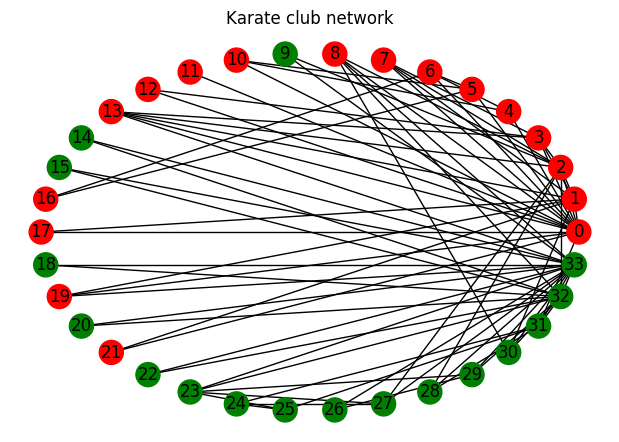

In [5]:
plt.figure(dpi=100)
pos = nx.circular_layout(G)
node_color = ['r' if G.nodes[v]['club'] == 'Mr. Hi' else 'g' for v in G]
nx.draw(G, pos=pos, with_labels=True, node_color=node_color)
plt.title('Karate club network')
plt.show()

## Node Embeddings with Random Weights <a id='nodeemb'></a>

In this section, we start with an untrained GCN model with random weights to see if it can serve as a feature extractor for nodes in the graph. Accordingly, we consider the following two-layer GCN:
$$
H_2 = \sigma ( \hat A H_1 W_2 ),
$$
where
$$
H_1 =  \sigma ( \hat A  X W_1 ),
$$
where 
- $\sigma ( . )$ is an activation function like relu;
- $W_1$ denotes input-to-hidden weight matrix;
- $W_2$ denotes hidden-to-output weight matrix;
- $X$ is the node feature matrix. Here, I take a featureless approach by setting $X = I_N$ , where $I_N$ is the $N$ by $N$ identity matrix where $N$ is the number of nodes in the graph;
- $\hat A$ is defined as 
$$
\hat A =  \hat D^{-1/2} (A + I) \hat D^{-1/2} ,
$$
where $A$ is the adjacency matrix of the graph, and $\hat D$ deontes the diagonal node-degree matrix of $A+I$.


In [6]:
# order the data
order = sorted(list(G.nodes()))

# Create an adjacency matrix from the data
A = nx.to_numpy_matrix(G, nodelist= order) 

# Create an identity matrix from the data
I = np.eye(*A.shape)

# Add a self-loop to each node
A_tilde = A.copy() + I

# Create the diagonal node-degree matrix of A_tilde
D_hat = np.array(np.sum(A_tilde, axis=0))[0]

# Apply symmetric normalization
D_inv = np.matrix(np.diag(D_hat**(-0.5)))
A_hat = D_inv * A_tilde * D_inv

# define feature matrix 
X = I 

In [7]:
# Weights initialization
n_input = 34    # Input layer dimension
n_hidden = 4    # Hidden layer dimension
n_embedding = 2 # Node embedding dimension

np.random.seed(123)

# Input to hidden weights
W_1 = np.random.normal(loc=0, scale=1, size=(n_input, n_hidden)) 

# Hidden to output weights
W_2 = np.random.normal(loc=0, size=(n_hidden, n_embedding))

In [8]:
# Define a GCN layer, include the ReLU Activation function
def relu(x):
    return np.maximum(x, 0, x)
    
def gcn_layer(A_hat, X, W):
    return relu(A_hat * X * W)

In [9]:
# Stack the GCN layers
H_1 = gcn_layer(A_hat, X, W_1)
H_2 = gcn_layer(A_hat, H_1, W_2)
output = H_2

print('Output shape:', output.shape)

Output shape: (34, 2)


Let's plot the embeddings generated from our untrained 2-layer GCN model with random weights. Colors denote class.

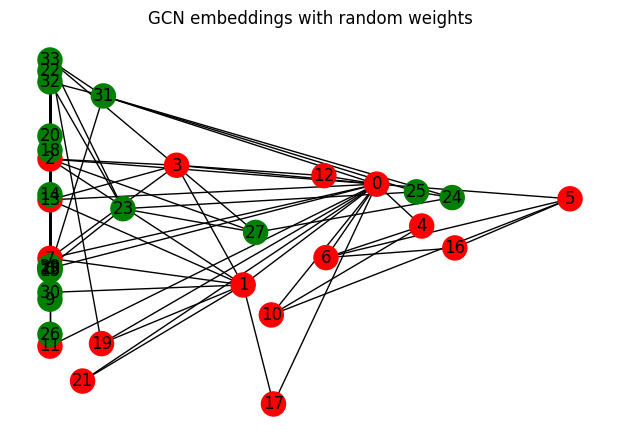

In [10]:
plt.figure(dpi=100)
# Extract the feature representations
feature_representations = {node: np.array(output)[node] for node in G.nodes()}
# Plot the embeddings
nx.draw(G, pos= feature_representations, with_labels=True, node_color=node_color)
plt.title('GCN embeddings with random weights')
plt.show()

## Semi-supervised Node Classification <a id='semisuper'></a>

Following [1], a multi-layer GCN has the following layer-wise propagation rule:
$$
H_{l+1} = \sigma (  \hat A  H_l W_l ),
$$
where
$$
\hat A =  \hat D^{-1/2} (A + I) \hat D^{-1/2} ,
$$
where 
- $\sigma ( . )$ is an activation function;
- $W_l$ is a trainable weight matrix in the $l$-th layer;
- $H_l$ is is the matrix of activations in the $l$-th layer; 
- $H_0 = X$ is the node feature matrix.

The problem of calssifying nodes in a graph, where labels are only available for a small subset of nodes can be fromulated as the following:
$$
\mathcal{L} = \mathcal{L}_0 + \lambda \mathcal{L}_{reg}
$$
where 
- $\mathcal{L}_0$ is the supervised loss (e.g. cross entropy loss) over all labeled part of the graph;
- $\lambda$ is a weighing factor;
- $\mathcal{L}_{reg}$ is a graph-based regularization term considerd as
$$
\mathcal{L}_{reg} = || ZZ^T - \hat A||_F,
$$
where $Z$ is the output of the GCN, and $|| .||_F$ is the Frobenius norm. 

In continue, I implement the semi-sueprvised node classfication problem for Zachary's karate club dataset. Note that, since this is a semi-superivsed learning setting, I only assign labels to the instructor (node 0) and the club president (node 33).

In [11]:
# These two functions borrowed from [2] 

def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

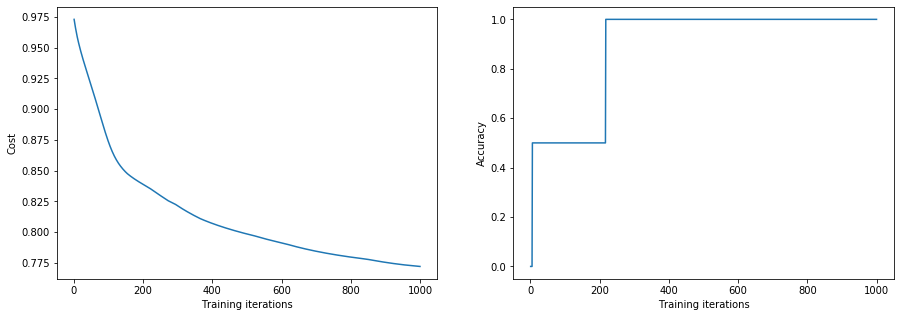

In [14]:
A_Hat = tf.constant(A_hat, 'float')
# ---------------------------------------------------------------- 
X_train = I

node_labels = [1 if G.nodes[v]['club'] == 'Mr. Hi' else 0 for v in G]
y_train = np.array(node_labels)
Y_train = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1, 1))
Y_train = Y_train.toarray()

X = tf.placeholder('float', [X_train.shape[0], X_train.shape[1]],name = 'X')  
Y = tf.placeholder('float', [Y_train.shape[0], Y_train.shape[1]],name = 'Y') 
mask = tf.placeholder('float', [X_train.shape[0]],name = 'Mask') 
# ---------------------------------------------------------------- 
# Trainable parameters
n_input = 34
n_hidden = 4
n_classes = 2

params = {
    # Input to hidden weights
    'W_1': tf.Variable(tf.random_normal([n_input, n_hidden], mean= 0, stddev= 1), name = 'W_1'),
    # Hidden to output weights
    'W_2': tf.Variable(tf.random_normal([n_hidden, n_classes], mean= 0, stddev= 1), name = 'W_2')
}
# ---------------------------------------------------------------- 
def GCN_supervised(X, params):
    layer_1 = tf.matmul(tf.matmul(A_Hat, X), params['W_1'])
    layer_1 = tf.nn.relu(layer_1, name = 'layer_1')  
    output = tf.matmul(tf.matmul(A_Hat, layer_1), params['W_2'], name = 'output_layer') 
    return output

Z = GCN_supervised(X, params)
Y_prob = tf.nn.softmax(Z, name = 'Y_prob')

mask_tr = np.zeros(34)
mask_tr[[0, 33]] = 1
mask_tr = np.array(mask_tr, dtype=np.bool)

fro = tf.matmul(Z, tf.transpose(Z)) - A_Hat
reg = tf.sqrt(tf.reduce_sum(tf.square(fro)))

lambdaa = 0.1
cost = masked_softmax_cross_entropy(preds = Y_prob, labels = Y, mask = mask_tr) + lambdaa * reg
# ---------------------------------------------------------------- 
num_epochs = 1000
learning_rate = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) 

accuracy = masked_accuracy(preds = tf.round(Y_prob), labels = Y, mask = mask_tr)
# ----------------------------------------------------------------
# Global variables initializer 
init = tf.global_variables_initializer() 
# Starting the Tensorflow Session 
with tf.Session() as sess:       
    # Initializing the variables 
    init.run()  

    cost_history = []
    accuracy_history = [] 
    embeddings = []
    for epoch in range(num_epochs):    
        # Running the optimizer 
        sess.run(optimizer, feed_dict={X: X_train, Y: Y_train, mask: mask_tr}) 
                 
        # Calculating & storing cost, accuracy and embeddings on current epoch 
        c, acc, z = sess.run([cost, accuracy, Z], feed_dict = {X: X_train, Y: Y_train, mask: mask_tr}) 
        cost_history.append(c) 
        accuracy_history.append(acc)
        embeddings.append(z)
# ----------------------------------------------------------------
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(np.arange(1, len(cost_history)+1), cost_history) 
plt.xlabel('Training iterations')
plt.ylabel('Cost')

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(accuracy_history)+1), accuracy_history) 
plt.xlabel('Training iterations')
plt.ylabel('Accuracy');

Here, I visulize the node embeddings react during training on a semi-supervised classification task. The embeddings (outputs Z) obtained from the two-layer GCN model applied to the karate club network. 

In [15]:
fig= plt.figure(dpi=150)
ax = fig.subplots()

def draw_embeddings(i):
    output = embeddings[i]
    feature_representations = {node: np.array(output)[node] for node in G.nodes()}
    
    ax.cla()
    ax.axis('off')
    ax.set_title('Karate club network node embeddings for epoch: %d' % i)    
    nx.draw_networkx(G, pos= feature_representations, node_color=node_color,
            with_labels=True, node_size=300, ax=ax)
    plt.close()
plt.close()

In [16]:
anim = animation.FuncAnimation(fig, draw_embeddings, frames=len(embeddings), interval=20)
HTML(anim.to_html5_video())

## Summary <a id='summary'></a>

In this notebook, we practiced how to implement GCNs from scratch. 
We started with an untrained GCN model with random weights. We showed that even the untrained model can serve as a feature extractor for nodes in the graph. Finally, we extended the model to a semi-supervised learning task where we have access to only few labelled nodes. We showed that how we can leverage GCN to classify nodes for this type of setting.

## Reference <a id='ref'></a>

[1] T. Kipf and M. Welling, "Semi-supervised classification with graph convolutional networks", ICLR 2016.

[2] https://github.com/tkipf/gcn/